In [1]:
import pandas as pd 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("C:/git/climate-question-answering")
sys.path.append("/mnt/c/git/climate-question-answering")
sys.path.append("/home/tim/ai4s/climate_qa/climate-question-answering")

from dotenv import load_dotenv
load_dotenv()

True

# Import objects

In [2]:
from climateqa.engine.llm import get_llm
from climateqa.engine.llm.ollama import get_llm as get_llm_ollama

llm = get_llm(provider="openai")
# llm = get_llm_ollama(model = "llama3")

In [3]:
from climateqa.engine.reranker import get_reranker

# reranker = get_reranker("large")
reranker = get_reranker("nano")
# from rerankers import Reranker
# # Specific flashrank model.
# # reranker = Reranker('ms-marco-TinyBERT-L-2-v2', model_type='flashrank')
# # reranker = Reranker('ms-marco-MiniLM-L-12-v2', model_type='flashrank')
# # reranker = Reranker('cross-encoder/ms-marco-MiniLM-L-4-v2', model_type='cross-encoder')
# # reranker = Reranker("mixedbread-ai/mxbai-rerank-xsmall-v1", model_type='cross-encoder')
# # reranker = Reranker("mixedbread-ai/mxbai-rerank-xsmall-v1", model_type='cross-encoder')
# reranker = Reranker("cohere", lang='en', api_key = "XXX")

/home/tim/anaconda3/envs/climateqa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


In [4]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore
from climateqa.engine.embeddings import get_embeddings_function
from climateqa.knowledge.retriever import ClimateQARetriever

embeddings_function = get_embeddings_function()
vectorstore = get_pinecone_vectorstore(embeddings_function)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Loading embeddings model:  BAAI/bge-base-en-v1.5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
/home/tim/ai4s/climate_qa/climate-question-answering/climateqa/engine/vectorstore.py:38: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  vectorstore = PineconeVectorstore(


In [5]:
import torch

In [6]:
torch.cuda.is_available()

False

# Semantic Routing

In [7]:
from climateqa.engine.chains.intent_categorization import make_intent_categorization_chain

In [16]:
cat_chain = make_intent_categorization_chain(llm)

In [17]:
# for question in SAMPLE_QUESTIONS:
#     output = router_chain.invoke({"input":question})
#     print(question)
#     print(output)
#     print("-"*100)
#     break

In [ ]:
cat_chain.invoke({"input":"Which industries have the highest GHG emissions?"})

In [19]:
from climateqa.knowledge.openalex import OpenAlexRetriever
from climateqa.engine.chains.keywords_extraction import make_keywords_extraction_chain

In [20]:
kec = make_keywords_extraction_chain(llm)

In [ ]:
output = kec.invoke("What is the environmental footprint of artificial intelligence")

In [ ]:
output

In [23]:
ROUTING_INDEX = {
    "Vector":["IPCC","IPBES","IPOS"],
    "OpenAlex":["OpenAlex"],
}

POSSIBLE_SOURCES = [y for values in ROUTING_INDEX.values() for y in values]

In [12]:
questions = [
    {"question":"What is climate change ?","sources":["IPCC","IPBES"]},
    {"question":"What is the link between El Nino and climate change ?","sources":["IPCC","OpenAlex"]},
]

state = {"remaining_questions":questions,"auto_mode":False,"sources_input":["OpenAlex"]}

In [13]:
# from climateqa.engine.chains.search import make_search_node
from climateqa.engine.graph import search


In [14]:
state.update(search(state))
state

{'remaining_questions': [{'question': 'What is climate change ?',
   'sources': ['IPCC', 'IPBES']},
  {'question': 'What is the link between El Nino and climate change ?',
   'sources': ['IPCC', 'OpenAlex']}],
 'auto_mode': False,
 'sources_input': ['OpenAlex']}

In [26]:
from climateqa.engine.chains.retrieve_documents import make_retriever_node

In [27]:
retrieve = make_retriever_node(vectorstore,reranker,llm)

In [ ]:
new_state = await retrieve.ainvoke(state)

In [ ]:
len(new_state["documents"])

In [ ]:
new_state["documents"][1]["reranking_score"]

In [ ]:
set(["IPCC","OpenAlex"]).intersection(set(["IPCC","IPBES","IPOS"]))

In [ ]:
new_questions = []

for q in questions:
    question,sources = q["question"],q["sources"]

    for index,index_sources in ROUTING_INDEX.items():
        selected_sources = list(set(sources).intersection(index_sources))
        new_questions.append({"question":question,"sources":selected_sources,"index":index})

new_questions

In [199]:
oa = OpenAlex()

In [216]:
test = oa.search("warming AND impoverished communities")

In [ ]:
test

In [ ]:
test[["title","abstract"]].isnull().sum()

##### test["content"].dropna()

In [218]:
oa = OpenAlexRetriever(min_year = 1960)

In [232]:
docs = oa.invoke("cloud formations AND Earth's radiative balance")

In [ ]:
docs[0]

In [ ]:
docs[0].metadata

# Query Rewriter

In [8]:
from climateqa.engine.chains.query_transformation import make_query_rewriter_chain,make_query_decomposition_chain
from climateqa.engine.chains.translation import make_translation_chain

In [9]:
rewriter_chain = make_query_rewriter_chain(llm)
translation_chain = make_translation_chain(llm)
decomposition_chain = make_query_decomposition_chain(llm)
router_chain = make_intent_router_chain(llm)

In [10]:
def transform_query(user_input):
    
    state = {"user_input":user_input}
    
    # Route
    output_router = router_chain.invoke({"input":user_input})
    if "language" not in output_router: output_router["language"] = "English"
    state.update(output_router)
    
    # Translation
    if output_router["language"].lower() != "english":
        translation = translation_chain.invoke({"input":user_input})
        state["query"] = translation["translation"]
    else:
        state["query"] = user_input
        
    # Decomposition
    decomposition_output = decomposition_chain.invoke({"input":state["query"]})
    state.update(decomposition_output)
    
    # Query Analysis
    questions = []
    for question in state["questions"]:
        question_state = {"question":question}
        analysis_output = rewriter_chain.invoke({"input":question})
        question_state.update(analysis_output)
        questions.append(question_state)
    state["questions"] = questions
    
    return state

In [ ]:
# question = "Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications ?"
question = "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
question = "I need to search the president of the United States, find their age, then find how old they will be in June 2023."
question = "What does Morrison argue about IK and LK on internal migration ?"
state = transform_query(question)
state

In [ ]:
questions = [
    "Super thanks, Which industries have the highest GHG emissions?",
    "How do you compare the view on biodiversity between the IPCC and IPBES ?",
    "Est-ce que l'IA a un impact sur l'environnement ?",
    "Que dit le GIEC sur l'impact de l'IA",
    "Franchement je sais pas trop de quoi on parle là, qui sont les membres du GIEC en fait ? Et quelles sont leurs dernières publications ?",
    "Ok that's nice, but I don't really understand. What is the impact of El Nino ?",
    "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?",
    "Which industries have the highest GHG emissions?",
    "What are invasive alien species and how do they threaten biodiversity and ecosystems?",
    "Are human activities causing global warming?",
    "What is the motivation behind mining the deep seabed?",
    "Tu peux m'écrire un poème sur le changement climatique ?",
    "Tu peux m'écrire un poème sur les bonbons ?",
    "What will be the temperature in 2100 in Strasbourg?",
    "C'est quoi le lien entre biodiversity and changement climatique ?",
    "Can you tell me more about ESRS2 ?"
]

question = questions[0]
question

In [ ]:
question = "Very nice thank you, What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
output = rewriter_chain.invoke({"input":question})
output

In [ ]:
for question in questions:
    print(question)
    output = transform_query(question)
    print(output)
    print("-"*100)

In [ ]:
rewriter_chain.invoke({"input":question})

# Langgraph
Inspired from https://colab.research.google.com/drive/1WemHvycYcoNTDr33w7p2HL3FF72Nj88i?usp=sharing#scrollTo=YJ77ZCzkiGTL

## Graph

In [7]:
from climateqa.engine.graph import make_graph_agent,display_graph
agent = make_graph_agent(llm,vectorstore,reranker)

TypeError: make_graph_agent() missing 1 required positional argument: 'reranker'

In [ ]:
display_graph(agent)

In [ ]:
verbose = False
# question = "What does the IPCC and IPBES think about deforestation ?"
# question = "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
# question = "Are human activities causing global warming?"
# question = "What are the evidence of climate change?"
# question = "What specific mechanisms link solar activity, particularly sunspots, to changes in global climate?"
# question = "In what ways does warming specifically help impoverished communities?"
question = "What's the impact of PFAS on babies ?"

steps_display = {
    "categorize_intent":("... Analyzing user message",True),
    "transform_query":("... Thinking step by step to answer the question",True),
    # "retrieve_documents":("... Searching in the knowledge base",False),
}

def display_steps(event):

    for event_name,(event_description,display_output) in steps_display.items():
        if event["name"] == event_name:
            if event["event"] == "on_chain_start":
                print(event_description)
            elif event["event"] == "on_chain_end":
                if display_output:
                    print(event["data"]["output"])
    if event["name"] == "log_retriever" and event["event"] == "on_chain_start":
        question = event["data"]["input"]["question"]
        sources = event["data"]["input"]["sources"]
        print(f"""... Searching for "{question}" in {", ".join(sources)}""")

async for event in agent.astream_events({"user_input":question,"sources_input":["IPCC"],"sources_auto":False,"audience":"experts"},version = "v1"):
# async for event in agent.astream_log({"user_input":question,"sources_input":["auto"],"audience":"experts"}):

    if verbose:
        print(str(event)[:1000])
        print("-"*50)
    else:
    
        if event["event"] == "on_chat_model_stream":
            print(event["data"]["chunk"].content,end = "")

        if event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
            docs = event["data"]["output"]["documents"]
            
        display_steps(event)
        

In [ ]:
docs

In [ ]:
output = await agent.ainvoke({"user_input":"C'est quoi l'empreinte carbone de l'IA"})
output

## Test simple route chains

In [36]:
from climateqa.engine.chains.answer_chitchat import make_chitchat_chain
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_chain

chitchat_chain = make_chitchat_chain(llm)
ai_impact_chain = make_ai_impact_chain(llm)

In [ ]:
async for event in ai_impact_chain.astream_events({"question":"Mais c'est quoi l'empreinte carbone de cet outil, ça doit consommer pas mal ..."},version = "v1"):
    if event["event"] == "on_chain_stream":
        print(event["data"]["chunk"],end = "")

In [ ]:
async for event in chitchat_chain.astream_events({"question":"Vas y blbablablala"},version = "v1"):
    if event["event"] == "on_chain_stream":
        print(event["data"]["chunk"],end = "")

In [16]:
from langchain.schema import Document
from langgraph.graph import END, StateGraph

## Retriever & Reranker

In [ ]:
query = "Is global warming caused by humans?"

retriever = ClimateQARetriever(
    vectorstore=vectorstore,
    sources = ["IPCC"],
    # reports = ias_reports,
   min_size = 200,
   k_summary = 5,k_total = 100,
   threshold = 0.5,
)

docs_question = retriever.get_relevant_documents(query)
len(docs_question)

In [ ]:
%%time
from scipy.special import expit, logit

def rerank_docs(reranker,docs,query):
    
    # Get a list of texts from langchain docs
    input_docs = [x.page_content for x in docs]
    
    # Rerank using rerankers library
    results = reranker.rank(query=query, docs=input_docs)

    # Prepare langchain list of docs
    docs_reranked = []
    for result in results.results:
        doc_id = result.document.doc_id
        doc = docs[doc_id]
        doc.metadata["rerank_score"] = result.score
        doc.metadata["query_used_for_retrieval"] = query
        docs_reranked.append(doc)
    return docs_reranked

docs_reranked = rerank_docs(reranker,docs_question,query)

In [ ]:
docs_reranked[0]

In [ ]:
def divide_into_parts(target, parts):
    # Base value for each part
    base = target // parts
    # Remainder to distribute
    remainder = target % parts
    # List to hold the result
    result = []
    
    for i in range(parts):
        if i < remainder:
            # These parts get base value + 1
            result.append(base + 1)
        else:
            # The rest get the base value
            result.append(base)
    
    return result

divide_into_parts(15,3)

In [ ]:
questions = 

In [133]:
state = {'query': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?",
 'questions': [{'question': "What role do cloud formations play in modulating the Earth's radiative balance?",
   'sources': ['IPCC']},
  {'question': 'How are cloud formations represented in current climate models?',
   'sources': ['IPCC']}]}

In [177]:
state = {'query': "What does Morrison argue about the role of IK and LK ?",
 'questions': [{'question': "How is the manga One Piece cited in the IPCC",
   'sources': ['IPCC']}]}

In [178]:
import sys
import os
from contextlib import contextmanager

@contextmanager
def suppress_output():
    # Open a null device
    with open(os.devnull, 'w') as devnull:
        # Store the original stdout and stderr
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        # Redirect stdout and stderr to the null device
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            # Restore stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [179]:
def retrieve_documents(state):
    
    POSSIBLE_SOURCES = ["IPCC","IPBES","IPOS","OpenAlex"]
    questions = state["questions"]
    
    # Use sources from the user input or from the LLM detection
    sources_input = state["sources_input"] if "sources_input" in state else ["auto"]
    auto_mode = "auto" in sources_input
    
    # Constants
    k_final = 15
    k_before_reranking = 100
    k_summary = 5
    rerank_by_question = True
    
    # There are several options to get the final top k
    # Option 1 - Get 100 documents by question and rerank by question
    # Option 2 - Get 100/n documents by question and rerank the total
    if rerank_by_question:
        k_by_question = divide_into_parts(k_final,len(questions))
    
    docs = []
    
    for i,q in enumerate(questions):
        
        sources = q["sources"]
        question = q["question"]
        
        # If auto mode, we use the sources detected by the LLM
        if auto_mode:
            sources = [x for x in sources if x in POSSIBLE_SOURCES]
            
        # Otherwise, we use the config
        else:
            sources = sources_input
            
        # Search the document store using the retriever
        # Configure high top k for further reranking step
        retriever = ClimateQARetriever(
            vectorstore=vectorstore,
            sources = sources,
            # reports = ias_reports,
           min_size = 200,
           k_summary = k_summary,k_total = k_before_reranking,
           threshold = 0.5,
        )
        docs_question = retriever.get_relevant_documents(question)
        
        # Rerank
        with suppress_output():
            docs_question = rerank_docs(reranker,docs_question,question)
        
        # If rerank by question we select the top documents for each question
        if rerank_by_question:
            docs_question = docs_question[:k_by_question[i]]
            
        # Add sources used in the metadata
        for doc in docs_question:
            doc.metadata["sources_used"] = sources
        
        # Add to the list of docs
        docs.extend(docs_question)
        
    # Sorting the list in descending order by rerank_score
    # Then select the top k
    docs = sorted(docs, key=lambda x: x.metadata["rerank_score"], reverse=True)
    docs = docs[:k_final]
    
    new_state = {"documents":docs}
    return new_state

def search(state):
    return {}

In [ ]:
%%time
output = retrieve_documents(state)

In [ ]:
rerank_scores = np.array([doc.metadata["rerank_score"] for doc in output["documents"]])
print(rerank_scores)
print(np.mean(rerank_scores))

In [ ]:
for doc in output["documents"]:
    print(doc)
    print("")

## Create the RAG

In [ ]:

# async def answer_ai_impact(state,config):
#     answer = await ai_impact_chain.ainvoke({"question":state["user_input"]},config)
#     return {"answer":answer}
            
async def answer_rag(state):
    
    # Get the docs
    docs = state["documents"]
    
    # Compute the trust average score
    rerank_scores = np.array([doc.metadata["rerank_score"] for doc in docs])
    trust_score = np.mean(rerank_scores)
    
    # 
    answer = "\n".join([x["question"] for x in state["questions"]])
    return {"answer":answer}

## Test the graph

In [10]:
from climateqa.engine.graph import make_graph_agent,display_graph

# app = make_graph_agent(llm,vectorstore,reranker)

from langchain_chroma import Chroma

vectorstore_graphs = Chroma(persist_directory="/home/tim/ai4s/climate_qa/climate-question-answering/data/vectorstore_owid", embedding_function=embeddings_function)
app = make_graph_agent(llm, vectorstore_ipcc= vectorstore, vectorstore_graphs = vectorstore_graphs, reranker=reranker)


INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


---- Translate query ----


ValueError: Node `retrieve_graphs_chitchat` is not reachable

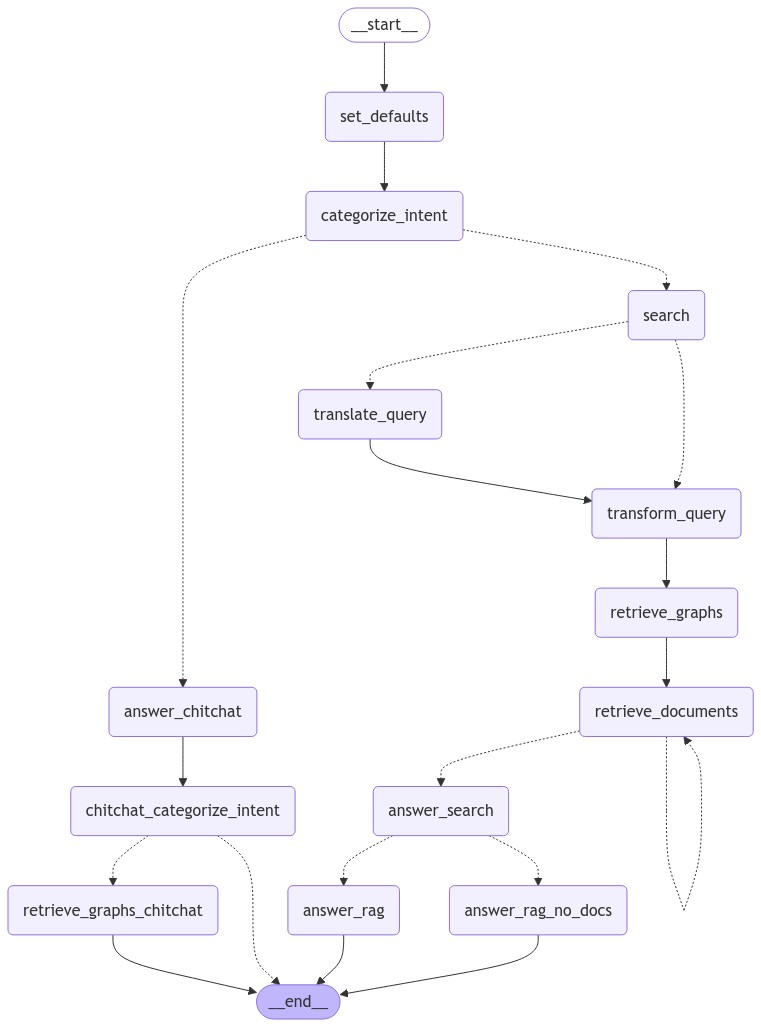

In [8]:
display_graph(app)

In [9]:
# question = "Tu penses quoi de Shakespeare ?"
question = "C'est quoi la recette de la tarte aux pommes ?"
question = "C'est quoi l'impact de ChatGPT ?"
question = "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"
question = "What evidence do we have of climate change and are human activities responsible for global warming?"
events_list = []
async for event in app.astream_events({"user_input": question,"sources":["auto"], "audience" : 'expert'}, version="v1"):
    events_list.append(event)

    if event["event"] == "on_chat_model_stream":
        token = event["data"]["chunk"].content
        print(token,end = "")
    else :
        events_list.append(event)
        # print(event)
        # print("")

NameError: name 'app' is not defined

In [11]:
steps_display = {
    "categorize_intent":("🔄️ Analyzing user message",True),
    "transform_query":("🔄️ Thinking step by step to answer the question",True),
    "retrieve_documents":("🔄️ Searching in the knowledge base",False),
}

In [13]:
nodes =[]
for event in events_list:
    # print("event",event["event"],"name",event["name"], "metadata", event["metadata"])
    if "langgraph_node" in event["metadata"]:
        nodes.append(event["metadata"]["langgraph_node"])
        
        
        # print("node : ", event["metadata"]["langgraph_node"], "event",event["event"],"name",event["name"])
    # print(event["event"],"name",event["name"])
    # if event["event"] == "on_chat_model_stream":
    #     print(event)

    # if event["name"] in steps_display.keys() and event["event"] == "on_chain_end": #display steps
        # if event["event"] == "on_chain_end" and event["name"] == "transform_query": #display steps
        # if  event["name"] == "transform_query": #display steps
        #     print(event)
        
    # if event["name"] != "transform_query" and event["event"] == "on_chat_model_stream":
    #     print(event)
    if event["name"] == "categorize_intent":
        print(event)

{'event': 'on_chain_start', 'name': 'categorize_intent', 'run_id': '3ad80670-fa9e-4964-9961-f61d3d51b31b', 'tags': ['graph:step:1'], 'metadata': {'langgraph_step': 1, 'langgraph_node': 'categorize_intent', 'langgraph_triggers': ['start:categorize_intent'], 'langgraph_path': ('__pregel_pull', 'categorize_intent'), 'langgraph_checkpoint_ns': 'categorize_intent:60ee815d-ddc7-53f9-ee31-896198d632db'}, 'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?", 'audience': 'expert'}}, 'parent_ids': []}
{'event': 'on_chain_start', 'name': 'categorize_intent', 'run_id': '3ad80670-fa9e-4964-9961-f61d3d51b31b', 'tags': ['graph:step:1'], 'metadata': {'langgraph_step': 1, 'langgraph_node': 'categorize_intent', 'langgraph_triggers': ['start:categorize_intent'], 'langgraph_path': ('__pregel_pull', 'categorize_intent'), 'langgraph_checkpoint_ns': 'catego

NameError: name 'Document' is not defined

In [2]:
x["data"]["output"]

{'intent': 'search',
 'language': 'English',
 'query': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?"}

In [17]:
np.unique(nodes)

array(['__start__', 'answer_rag', 'answer_search', 'categorize_intent',
       'retrieve_documents', 'search', 'transform_query'], dtype='<U18')

In [13]:
events_list[:10]

[{'event': 'on_chain_start',
  'run_id': 'f405c636-8152-4d9f-ad15-f292600e7ae8',
  'name': 'LangGraph',
  'tags': [],
  'metadata': {},
  'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?",
    'sources': ['auto'],
    'audience': 'expert'}},
  'parent_ids': []},
 {'event': 'on_chain_start',
  'name': '__start__',
  'run_id': '3a1114ca-865e-48e5-bb41-74f2eeceacdf',
  'tags': ['graph:step:0', 'langsmith:hidden', 'langsmith:hidden'],
  'metadata': {'langgraph_step': 0,
   'langgraph_node': '__start__',
   'langgraph_triggers': ['__start__'],
   'langgraph_path': ('__pregel_pull', '__start__'),
   'langgraph_checkpoint_ns': '__start__:d7171ff5-c9e3-ff42-6716-523efb4f8ac0'},
  'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are 

In [10]:
events_list[0]

{'event': 'on_chain_start',
 'run_id': 'f405c636-8152-4d9f-ad15-f292600e7ae8',
 'name': 'LangGraph',
 'tags': [],
 'metadata': {},
 'data': {'input': {'user_input': "I am not really sure what you mean. What role do cloud formations play in modulating the Earth's radiative balance, and how are they represented in current climate models?",
   'sources': ['auto'],
   'audience': 'expert'}},
 'parent_ids': []}

In [11]:
set([event["event"] for event in events_list])

{'on_chain_end',
 'on_chain_start',
 'on_chain_stream',
 'on_chat_model_end',
 'on_chat_model_start',
 'on_parser_end',
 'on_parser_start',
 'on_prompt_end',
 'on_prompt_start',
 'on_retriever_end',
 'on_retriever_start'}

In [ ]:
events_list